In [29]:
import torch
import numpy as np
from collections import Counter


from model import TicTacToeModel
from modelCNN import TicTacToeCNN


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros(9, dtype=int)
        self.verbose = True

    def _display_board(self):
        if not self.verbose:
            return
        symbols = {0: ".", 1: "X", -1: "O"}
        for i in range(0, 9, 3):
            print(" ".join(symbols[self.board[j]] for j in range(i, i + 3)))
        print()
        
    def _reset_game(self):
        self.board = np.zeros(9, dtype=int)
        
    def _check_winner(self):
        win_indices = np.array([
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],
            [0, 3, 6],
            [1, 4, 7],
            [2, 5, 8],
            [0, 4, 8],
            [2, 4, 6],
        ])
        # x win
        if np.any(np.all(self.board[win_indices] == np.ones(3), axis=1)):
            return 1
        # 0 win
        elif np.any(np.all(self.board[win_indices] == -np.ones(3), axis=1)):
            return -1
        # draw
        elif np.all(self.board != 0):  # No empty cells, draw
            return 0
        # none
        return None

    def play(self, player_x, player_o, verbose=False):
        self._reset_game()
        self.verbose = verbose
        current_player = 1
        players = {1: player_x, -1: player_o}
        self._display_board()

        while True:
            move = players[current_player].make_move(self.board.copy(), current_player)
            self.board[move] = current_player
            self._display_board()
            winner = self._check_winner()
            if winner is not None:
                return winner
            current_player *= -1


class RandomPlayer:
    def make_move(self, board, player):
        valid_actions = np.where(board == 0)[0]
        return np.random.choice(valid_actions)


class DeepPlayer:
    def __init__(self, model_path=None):
        self.model = self._get_model(model_path)
        
    def _get_model(self, path):
        model = torch.load(path).to(device)
        model.eval()
        return model

    def make_move(self, board, player):
        if self.model is None:
            raise ValueError(f"Модель не загружена.")
        board *= player
        board_tensor = torch.tensor(board, dtype=torch.float32).to(device)
        if isinstance(self.model, TicTacToeCNN):
            board_tensor = board_tensor.view(1, 1, 3, 3)
        with torch.no_grad():
            q_values = self.model(board_tensor).squeeze().cpu().numpy()
        available_moves = np.where(board == 0)[0]
        best_move = max(available_moves, key=lambda x: q_values[x])
        return best_move


In [31]:
model_path = r'.\models\model_conv_10000.pth'

player1 = DeepPlayer(model_path=model_path)
player2 = RandomPlayer()
game = TicTacToe()

history = []

for _ in range(1000):
    result = game.play(player_x=player1, player_o=player2, verbose=True)
    history.append(result)
    print(result)
history = Counter(history)
print(history)

C:\Users\Ilya\AppData\Local\Temp\ipykernel_19476\3498160689.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path).to(device)


. . .
. . .
. . .

. . .
. . .
. . X

. . .
. . .
O . X

. . X
. . .
O . X

O . X
. . .
O . X

O . X
. . X
O . X

1
. . .
. . .
. . .

. . .
. . .
. . X

. . .
. O .
. . X

. . .
. O .
X . X

. O .
. O .
X . X

. O .
. O .
X X X

1
. . .
. . .
. . .

. . .
. . .
. . X

O . .
. . .
. . X

O . .
. . .
X . X

O . O
. . .
X . X

O . O
. . .
X X X

1
. . .
. . .
. . .

. . .
. . .
. . X

. . .
O . .
. . X

. . .
O . .
X . X

. . O
O . .
X . X

. . O
O X .
X . X

O . O
O X .
X . X

O . O
O X .
X X X

1
. . .
. . .
. . .

. . .
. . .
. . X

. . .
. . .
. O X

. . .
. . .
X O X

. . .
. . O
X O X

. . X
. . O
X O X

. . X
O . O
X O X

X . X
O . O
X O X

X O X
O . O
X O X

X O X
O X O
X O X

1
. . .
. . .
. . .

. . .
. . .
. . X

. . .
. O .
. . X

. . .
. O .
X . X

O . .
. O .
X . X

O . X
. O .
X . X

O . X
. O O
X . X

O . X
. O O
X X X

1
. . .
. . .
. . .

. . .
. . .
. . X

. . .
. . .
O . X

. . X
. . .
O . X

. O X
. . .
O . X

. O X
. . X
O . X

1
. . .
. . .
. . .

. . .
. . .
. . X

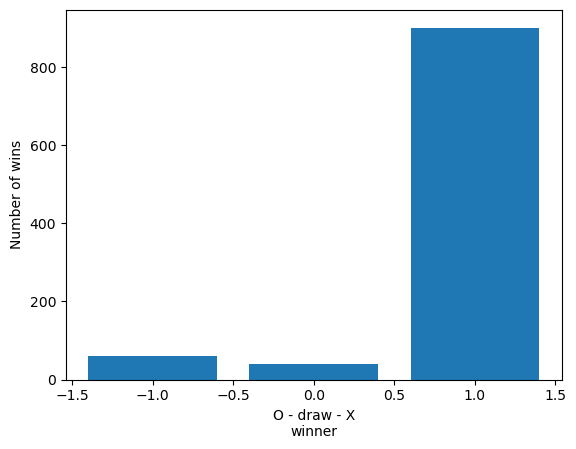

In [32]:
import matplotlib.pyplot as plt 


winner = history.keys()
numbers = history.values()
plt.bar(winner, numbers)
plt.xlabel("O - draw - X\nwinner")
plt.ylabel("Number of wins")
plt.show()